In [1]:
#Import pacage
import numpy as np
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import os
import datetime
import time

from config import api_key
from tickers import sector_symbol

In [2]:
# Looking at stock performance by industry relevant indexes

# Variable initialization
close_daily_price =[]
ticker_date = []
delta = datetime.timedelta(days=1)

# Search parameters
industry_index = ["XLE","XLK"]
start_date = datetime.datetime(2020,1,24)
end_date = datetime.datetime(2021,5,5)
base_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY'

# For loop to create the date column and create the results dataframe
while start_date <= end_date:
    
    ticker_date.append(start_date)
    
    # Building the results dataframe
    ticker_value_df = pd.DataFrame({'Date': ticker_date})
    
    start_date += delta
                                    
# Resetting start date
start_date = datetime.datetime(2019,8,1)
                                    
# For loop to make the call for every industry index and retrieving the data
for ticker in industry_index:
    
    # Building the search url
    url = f'{base_url}&symbol={ticker}&outputsize=full&apikey={api_key}'
    
    # Making the API call
    response = requests.get(url)
    response_json = response.json()
    
    #Progress tracker
    print (f'Processing {ticker} with code {response.status_code}')
    
    # Retrieving daily closing prices
    while start_date <= end_date:
    
        # Obtaining date as string
        string_date = start_date.strftime("%Y-%m-%d")

        # Exception for dates with no operation
        try:
            close_daily_price.append(float(response_json['Time Series (Daily)'][string_date]["4. close"]))
        except (KeyError):
            close_daily_price.append(0)  
        
        start_date += delta
                                    
    # Adding the current ticker to the dataframe
    ticker_value_df[ticker] = pd.Series(close_daily_price)
    close_daily_price.clear()
    start_date = datetime.datetime(2019,8,1)
    time.sleep(12)
    
print("API calls done")

Processing XLE with code 200
Processing XLK with code 200
API calls done


In [3]:
ticker_value_df

,Date,XLE,XLK
0,2020-01-24,61.28,80.36
1,2020-01-25,60.40,79.05
2,2020-01-26,0.00,0.00
3,2020-01-27,0.00,0.00
4,2020-01-28,58.60,75.75
...,...,...,...
463,2021-05-01,28.93,121.58
464,2021-05-02,0.00,0.00
465,2021-05-03,0.00,0.00
466,2021-05-04,33.06,120.70


In [4]:
#Read Cov File
cov_doc=pd.read_csv("../stocks-covid/covid19_by_country.csv")
cov_doc.head()

,Country,CountryAlpha3Code,Date,confirmed,deaths,recoveries,confirmed_inc,deaths_inc,recoveries_inc,ECR,GRTStringencyIndex,DaysSince1Cases,DaysSince100Cases,confirmed_PopPct,deaths_PopPct,recoveries_PopPct
0,Afghanistan,AFG,2020-01-22,0,0,0.0,32.0,0.0,6.0,0.0,0.0,-33,-66,0.0,0.0,0.0
1,Afghanistan,AFG,2020-01-23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,-32,-65,0.0,0.0,0.0
2,Afghanistan,AFG,2020-01-24,0,0,0.0,0.0,0.0,0.0,0.0,0.0,-31,-64,0.0,0.0,0.0
3,Afghanistan,AFG,2020-01-25,0,0,0.0,0.0,0.0,0.0,0.0,0.0,-30,-63,0.0,0.0,0.0
4,Afghanistan,AFG,2020-01-26,0,0,0.0,0.0,0.0,0.0,0.0,0.0,-29,-62,0.0,0.0,0.0


In [5]:
cov_doc["Date"]=pd.to_datetime(cov_doc["Date"],format="%Y-%m-%d")

In [6]:
cov_doc.dtypes

Country                       object
CountryAlpha3Code             object
Date                  datetime64[ns]
confirmed                      int64
deaths                         int64
recoveries                   float64
confirmed_inc                float64
deaths_inc                   float64
recoveries_inc               float64
ECR                          float64
GRTStringencyIndex           float64
DaysSince1Cases                int64
DaysSince100Cases              int64
confirmed_PopPct             float64
deaths_PopPct                float64
recoveries_PopPct            float64
dtype: object

In [7]:
#Groupby Gender total value
grup_bydate=cov_doc.groupby(["Date"]).sum()["confirmed_inc"]
grup_bydate.head()

cov_df=pd.DataFrame({"Confirmed":grup_bydate})
cov_df

,Confirmed
Date,
2020-01-22,124672.0
2020-01-23,98.0
2020-01-24,2989.0
2020-01-25,492.0
2020-01-26,8989.0
...,...
2021-05-01,177005639.0
2021-05-02,103913000.0
2021-05-03,158794058.0


In [8]:
# merging the dataframes
merged_data = pd.merge(ticker_value_df, cov_df , on = 'Date', how = 'outer')

merged_data

,Date,XLE,XLK,Confirmed
0,2020-01-24,61.28,80.36,2989.0
1,2020-01-25,60.40,79.05,492.0
2,2020-01-26,0.00,0.00,8989.0
3,2020-01-27,0.00,0.00,809.0
4,2020-01-28,58.60,75.75,2846.0
...,...,...,...,...
465,2021-05-03,0.00,0.00,158794058.0
466,2021-05-04,33.06,120.70,172822858.0
467,2021-05-05,34.13,118.45,179691156.0
468,2020-01-22,NaN,NaN,124672.0


In [9]:
# Cleaning the results dataframe

# Dropping rows with no values (no stocks operations)
clean_df = merged_data.loc[merged_data["XLE"]!=0].reset_index(drop=True)
clean_df

# Dropping columns with no data (Indexes not found in the API)

# Creating the list with tickers to keep
keep_columns = []

for column in clean_df:
    column_index = clean_df.columns.get_loc(column)   
    if clean_df.iloc[0, column_index] != 0:
        keep_columns.append(column)
        
clean_df = clean_df[keep_columns]
clean_df= clean_df.dropna(how="any")



The R squared is:0.26


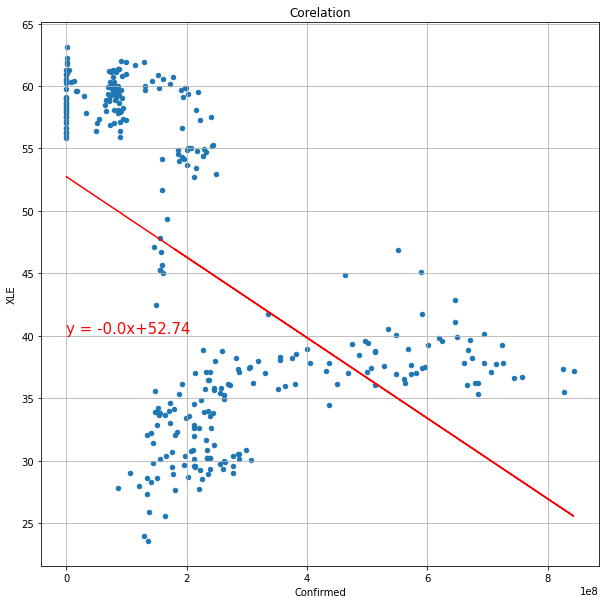

In [10]:
#Creatting the linear regression model

# Add the linear regression equation and line to plot

#setting x and y for line
x_values = clean_df['Confirmed']
y_values = clean_df['XLE']
(m, b, r, p, stderr) = st.stats.linregress(x_values, y_values)

clean_df.plot(kind="scatter", x="Confirmed", y="XLE", grid=True, figsize=(10,10),
                   title="Corelation")
line_eq = 'y = ' + str(round(m, 2)) + 'x+' + str(round (b, 2))
plt.annotate(line_eq,(22.1,40.2),fontsize=15,color="red")
plt.plot(x_values, m*x_values + b, color ='r')

print ('The R squared is:' + str(round(r**2, 2)))

The R squared is:0.31


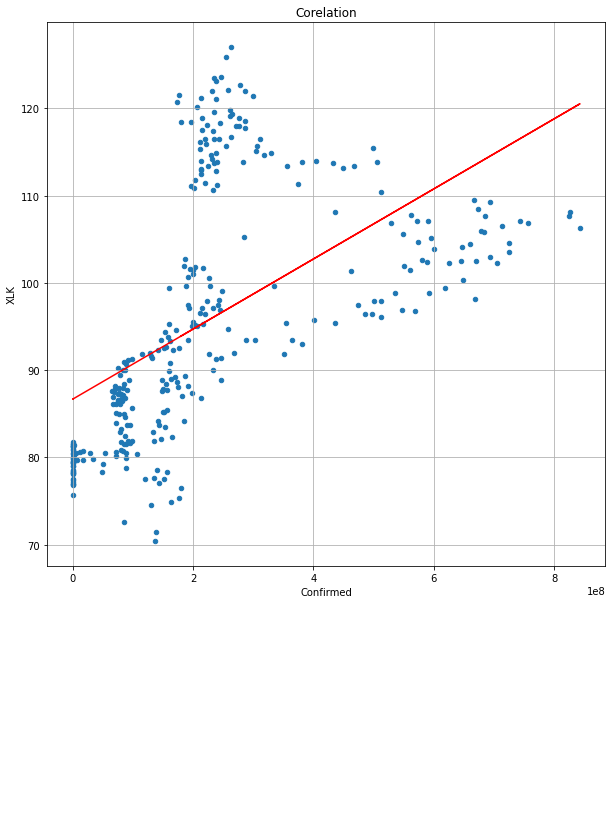

In [11]:
#Creatting the linear regression model

# Add the linear regression equation and line to plot

#setting x and y for line
x_values = clean_df['Confirmed']
y_values = clean_df['XLK']
(m, b, r, p, stderr) = st.stats.linregress(x_values, y_values)

clean_df.plot(kind="scatter", x="Confirmed", y="XLK", grid=True, figsize=(10,10),
                   title="Corelation")
line_eq = 'y = ' + str(round(m, 2)) + 'x+' + str(round (b, 2))
plt.annotate(line_eq,(22.1,40.2),fontsize=15,color="red")
plt.plot(x_values, m*x_values + b, color ='r')

print ('The R squared is:' + str(round(r**2, 2)))